<a href="https://colab.research.google.com/github/krisvijay0506/Team-Ninjas---fitness-coach-analytics/blob/main/Beam_Ninjas_%E2%80%93_Fitness_Tracker_Data_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Beam Ninjas – Fitness Tracker Data Pipeline**


As part of the Beam Ninjas team, we selected the challenge category "Data Pipeline Without Coding" to explore how low-code and serverless solutions like Apache Beam YAML + Google Cloud Dataflow can simplify data engineering workflows.


My teammates *Jincy* and *Dhiren* have already successfully implemented and tested low-code pipelines using Beam YAML on Dataflow, and performed performance benchmarking. Inspired by their work and as a fitness enthusiast myself I was curious to explore how a personal trainer can leverage Google Cloud services to better serve their clients.




**Project Idea**


The core idea is to process Fitbit fitness tracker data using Apache Beam, clean and transform the data in Google Colab, and then create interactive visualizations and analytical metrics that reflect user activity, calorie burn, and behavioral patterns.

The dataset used is an open-source Fitbit fitness dataset from Kaggle.





Link to the dataset : https://www.kaggle.com/datasets/arashnic/fitbit/data



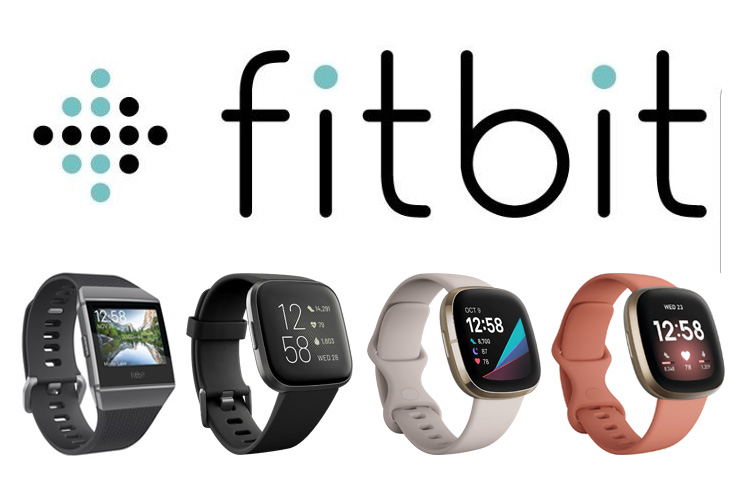

**Business Use Case**

This project simulates a real-world scenario where a fitness trainer monitors the performance of multiple clients and delivers bi-weekly reports with:


Total and weekly calorie burn



Activity level classification



Provide fitness routine recommendations based on observed trends



The trainer can use this data to design customized diet plans and fitness routines tailored to each client’s performance.



**Future Scope**

*   Convert Python Beam logic into a YAML pipeline for low-code deployment
    on Google Cloud Dataflow.
*   Run the pipeline on Dataflow for scalable, serverless batch processing
    of client fitness metrics.
*   Store aggregated results in BigQuery, partitioned by user and week for
    efficient querying
*   Build interactive dashboards in Looker to visualize client performance
    and bi-weekly insights
*   Integrate real-time data using Pub/Sub, enabling streaming from
    smartwatches and fitness apps
*   Enable secure sharing of fitness reports with family doctors via
    BigQuery access controls and Looker views

In [3]:
from typing_extensions import dataclass_transform
#Install Apache beam
!pip install --quiet apache-beam
!pip install --quiet 'apache-beam[yaml]'
!pip install --quiet 'apache-beam[interactive]'
#Create directories to store data,pipelines and results
! mkdir -p data
! mkdir -p pipelines
! mkdir -p results

In [9]:
#Code Snippet to download datasets from Kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/ # kaggle json API key to be provided for authentication
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d arashnic/fitbit

Dataset URL: https://www.kaggle.com/datasets/arashnic/fitbit
License(s): CC0-1.0
fitbit.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
!unzip fitbit.zip -d fitbit_data

Archive:  fitbit.zip
  inflating: fitbit_data/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/dailyActivity_merged.csv  
  inflating: fitbit_data/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/heartrate_seconds_merged.csv  
  inflating: fitbit_data/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/hourlyCalories_merged.csv  
  inflating: fitbit_data/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/hourlyIntensities_merged.csv  
  inflating: fitbit_data/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/hourlySteps_merged.csv  
  inflating: fitbit_data/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteCaloriesNarrow_merged.csv  
  inflating: fitbit_data/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteIntensitiesNarrow_merged.csv  
  inflating: fitbit_data/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteMETsNarrow_merged.csv  
  inflating: fit

Upon initial exploration, we observed that the extracted Fitbit datasets contain detailed physical activity, health, and behavioral metrics from Fitbit users. The data spans a time period of approximately two months, specifically from:


**12 March, 2016 – April 11, 2016**

 **12 April, 2016 – 12 May, 2016**


The data is structured at multiple levels of granularity, enabling a wide range of analytics use cases:




**Daily level data**: Summarizes total steps, calories burned, distance traveled, activity intensity, and sleep metrics.





**Hourly level data**: Captures trends and patterns across different times of the day (e.g., hourly steps, intensity, calories).




**Minute level and second level data:** Provides high resolution insights into user behavior, including minute by minute steps, calorie burn, intensity, and second by second heart rate readings.

In [22]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
import pprint


#Load the Fitbit Dataset using pandas

df = pd.read_csv('/content/fitbit_data/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/dailyActivity_merged.csv')

# Clean and standardize
df.rename(columns={
    'Id': 'user_id',
    'ActivityDate': 'activity_date',
    'TotalSteps': 'total_steps',
    'Calories': 'calories',
    'VeryActiveMinutes': 'very_active_minutes',
    'FairlyActiveMinutes': 'fairly_active_minutes',
    'LightlyActiveMinutes': 'lightly_active_minutes',
    'SedentaryMinutes': 'sedentary_minutes',
    'TotalDistance': 'total_distance'
}, inplace=True)

# Convert date column
df['activity_date'] = pd.to_datetime(df['activity_date'])

#Display basic stats about the cleaned Fitbit dataset
print("Dataset Overview:\n")

print(f" Total number of records           : {len(df)}\n")

print(f" Number of Unique users            : {df['user_id'].nunique()}\n")

print(f" Date range of the data collected              : {df['activity_date'].min().date()} to {df['activity_date'].max().date()}\n")

print(f" Average steps per day   : {df['total_steps'].mean():,.0f}\n")

print(f"Average calories burned : {df['calories'].mean():,.0f}\n")

print(f"Number of Missing values in each column :\n{df.isnull().sum()}\n")

Dataset Overview:

 Total number of records           : 457

 Number of Unique users            : 35

 Date range of the data collected              : 2016-03-12 to 2016-04-12

 Average steps per day   : 6,547

Average calories burned : 2,189

Missing values:
user_id                     0
activity_date               0
total_steps                 0
total_distance              0
TrackerDistance             0
LoggedActivitiesDistance    0
VeryActiveDistance          0
ModeratelyActiveDistance    0
LightActiveDistance         0
SedentaryActiveDistance     0
very_active_minutes         0
fairly_active_minutes       0
lightly_active_minutes      0
sedentary_minutes           0
calories                    0
dtype: int64



In [24]:
# convert preprocessed dataframe into a Beam compatible input format(list of dictionaries having dictionary in each row)

records = df.to_dict(orient='records')

#
pprint.pprint(records[:3])

[{'LightActiveDistance': 4.07000017166138,
  'LoggedActivitiesDistance': 0.0,
  'ModeratelyActiveDistance': 0.46000000834465,
  'SedentaryActiveDistance': 0.0,
  'TrackerDistance': 7.1100001335144,
  'VeryActiveDistance': 2.5699999332428,
  'activity_date': Timestamp('2016-03-25 00:00:00'),
  'calories': 1819,
  'fairly_active_minutes': 12,
  'lightly_active_minutes': 205,
  'sedentary_minutes': 804,
  'total_distance': 7.1100001335144,
  'total_steps': 11004,
  'user_id': 1503960366,
  'very_active_minutes': 33},
 {'LightActiveDistance': 3.91000008583069,
  'LoggedActivitiesDistance': 0.0,
  'ModeratelyActiveDistance': 0.730000019073486,
  'SedentaryActiveDistance': 0.0,
  'TrackerDistance': 11.5500001907349,
  'VeryActiveDistance': 6.92000007629395,
  'activity_date': Timestamp('2016-03-26 00:00:00'),
  'calories': 2154,
  'fairly_active_minutes': 17,
  'lightly_active_minutes': 274,
  'sedentary_minutes': 588,
  'total_distance': 11.5500001907349,
  'total_steps': 17609,
  'user_id'

In [25]:
# As we are calculating the metrics for the data aggregated on a bi weekly basis lets create a function to create results for all the metrics
def enrich_record(row):
    row = dict(row)  # ensure mutability
    steps = row.get('total_steps', 0)
    vam = row.get('very_active_minutes', 0)
    fam = row.get('fairly_active_minutes', 0)
    lam = row.get('lightly_active_minutes', 0)
    calories = row.get('calories', 0)
    user_id = row.get('user_id')

    # Calculate bi-week number (1–26) based on day-of-year
    try:
        activity_date = pd.to_datetime(row.get('activity_date'))
        day_of_year = activity_date.timetuple().tm_yday
        biweek = (day_of_year - 1) // 14 + 1
        row['biweek'] = biweek
    except:
        row['biweek'] = None

    # Step-based activity classification
    if steps < 2500:
        row['step_category'] = 'Basic Activity'
    elif steps < 5000:
        row['step_category'] = 'Limited Activity'
    elif steps < 7500:
        row['step_category'] = 'Low Active'
    elif steps < 10000:
        row['step_category'] = 'Somewhat Active'
    elif steps < 12500:
        row['step_category'] = 'Active'
    else:
        row['step_category'] = 'Highly Active'

    # Activity level based on very active minutes
    if vam >= 60:
        row['activity_level'] = 'Highly Active'
    elif vam >= 30:
        row['activity_level'] = 'Active'
    else:
        row['activity_level'] = 'Sedentary'

    # Additional metrics
    row['cal_per_step'] = calories / steps if steps > 0 else 0
    row['total_active_minutes'] = vam + fam + lam
    row['engagement_score'] = (steps / 10000) + (row['total_active_minutes'] / 60) + (calories / 2000)
    row['low_step_day'] = steps < 5000
    row['user_id'] = user_id  # ensure key is retained

    return row

In [26]:
# This function summarizes a group of daily records into a bi-weekly report
def aggregate_biweekly(values):
    total_steps = sum(v['total_steps'] for v in values)
    total_calories = sum(v['calories'] for v in values)
    avg_active_minutes = sum(v['total_active_minutes'] for v in values) / len(values)
    low_step_days = sum(1 for v in values if v['low_step_day'])

    # Find the most common activity level and step category in the group
    most_common_activity = Counter([v['activity_level'] for v in values]).most_common(1)[0][0]
    most_common_step_cat = Counter([v['step_category'] for v in values]).most_common(1)[0][0]

    return {
        'total_steps': total_steps,
        'total_calories': total_calories,
        'avg_active_minutes': round(avg_active_minutes, 1),
        'low_step_days': low_step_days,
        'activity_level': most_common_activity,
        'step_category': most_common_step_cat
    }

In [27]:
# Define the pipeline and apply transformations
with beam.Pipeline(options=PipelineOptions()) as pipeline:
    enriched = (
        pipeline
        | "Create Input" >> beam.Create(records)
        | "Enrich Metrics" >> beam.Map(enrich_record)
        | "Filter Valid Dates" >> beam.Filter(lambda r: r['biweek'] is not None)
        | "Key By (user_id, biweek)" >> beam.Map(lambda r: ((r['user_id'], r['biweek']), r))
        | "Group by User + BiWeek" >> beam.GroupByKey()
        | "Aggregate" >> beam.Map(lambda kv: {
            'user_id': kv[0][0],
            'biweek': kv[0][1],
            **aggregate_biweekly(list(kv[1]))
        })
        | "To List" >> beam.combiners.ToList()
    )


    enriched_records = list(map(enrich_record, records))
    grouped = {}

    for r in enriched_records:
        key = (r['user_id'], r.get('biweek'))
        if key[1] is not None:
            grouped.setdefault(key, []).append(r)

    biweekly_summary = [
        {
            'user_id': uid,
            'biweek': bw,
            **aggregate_biweekly(rows)
        }
        for (uid, bw), rows in grouped.items()
    ]

    # Convert the result into a DataFrame for analysis and visualization
    df_biweek = pd.DataFrame(biweekly_summary)

In [34]:
# Display the first few rows of the final summary
df_biweek.sort_values(['user_id', 'biweek']).head(10)

,user_id,biweek,total_steps,total_calories,avg_active_minutes,low_step_days,activity_level,step_category
0,1503960366,7,174946,26734,303.8,0,Active,Active
1,1503960366,8,46224,7394,213.0,1,Active,Active
2,1624580081,7,49846,19196,114.2,12,Sedentary,Basic Activity
3,1624580081,8,30453,6509,145.2,2,Sedentary,Low Active
4,1644430081,7,69737,22457,331.9,2,Sedentary,Limited Activity
5,1644430081,8,23011,6707,179.0,1,Sedentary,Somewhat Active
6,1844505072,7,21406,11502,137.0,4,Sedentary,Low Active
7,1844505072,8,22281,7889,192.2,2,Sedentary,Low Active
8,1927972279,7,19790,16878,138.3,6,Sedentary,Basic Activity
9,1927972279,8,6380,10170,78.4,5,Sedentary,Basic Activity


Top 10 Users with Most Reduced Activity Days (<5000 steps/day):


,user_id,low_step_days
14,4057192912,25
1,1624580081,14
4,1927972279,11
33,8792009665,10
7,2320127002,10
13,4020332650,10
6,2026352035,9
30,8253242879,9
17,4445114986,9
23,6290855005,8


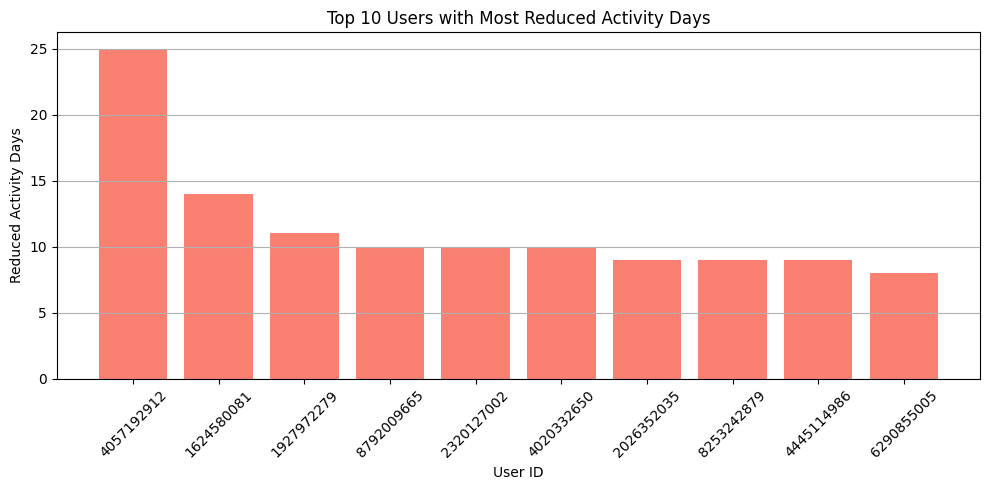

In [33]:
# Aggregate idle days per user from biweekly summary
idle_users = df_biweek.groupby("user_id")["low_step_days"].sum().reset_index()
idle_users_sorted = idle_users.sort_values("low_step_days", ascending=False)

# Display top 10 idle users
print("Top 10 Users with Most Reduced Activity Days (<5000 steps/day):")
display(idle_users_sorted.head(10))

# Bar chart with Matplotlib
import matplotlib.pyplot as plt

top_idle = idle_users_sorted.head(10)

plt.figure(figsize=(10, 5))
plt.bar(top_idle['user_id'].astype(str), top_idle['low_step_days'], color='salmon')
plt.xlabel("User ID")
plt.ylabel("Reduced Activity Days")
plt.title("Top 10 Users with Most Reduced Activity Days")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

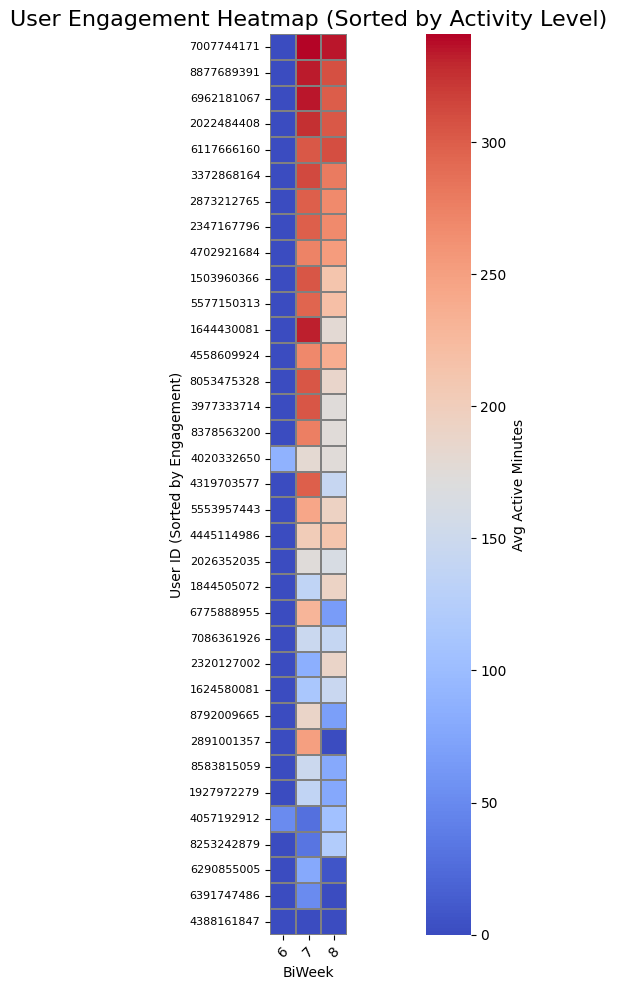

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Pivot data for heatmap
pivot_df = df_biweek.pivot_table(
    index='user_id',
    columns='biweek',
    values='avg_active_minutes',
    fill_value=0
)

# Sort users by overall average engagement
pivot_df['mean'] = pivot_df.mean(axis=1)
pivot_df = pivot_df.sort_values('mean', ascending=False).drop(columns='mean')

# Create heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(
    pivot_df,
    cmap='coolwarm',  # Different color scheme (blue to red)
    cbar=True,
    square=True,
    linewidths=0.3,
    linecolor='gray',
    cbar_kws={'label': 'Avg Active Minutes'}
)

# Customizing plot aesthetics
plt.title("User Engagement Heatmap (Sorted by Activity Level)", fontsize=16)
plt.xlabel("BiWeek")
plt.ylabel("User ID (Sorted by Engagement)")
plt.xticks(rotation=45)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

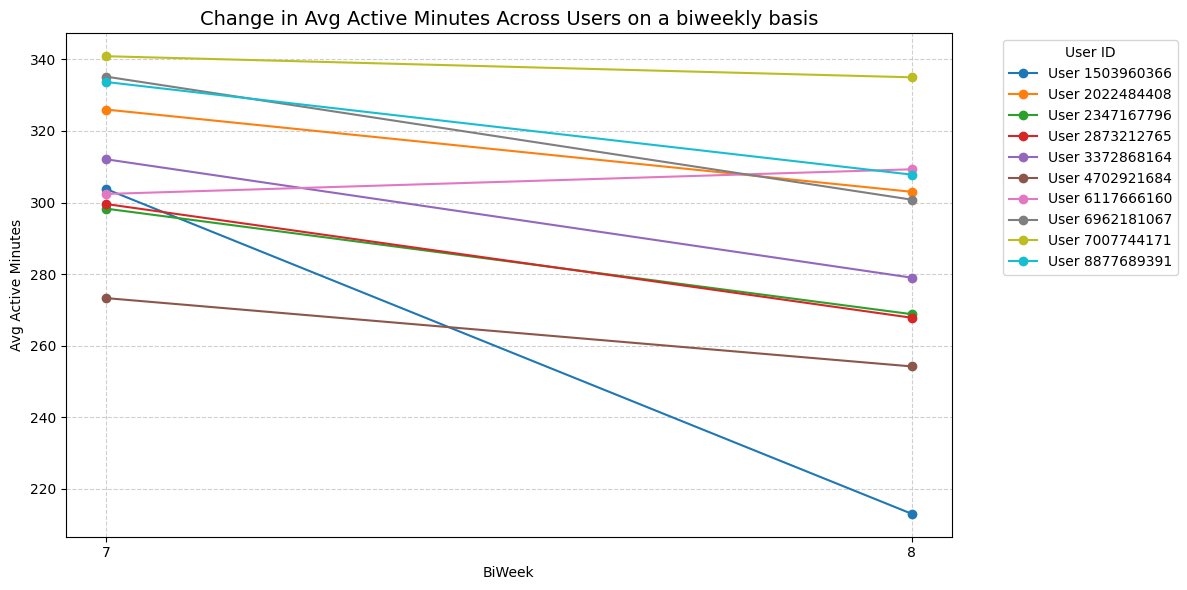

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Pick top 10 users with highest average activity
top_users = (
    df_biweek.groupby('user_id')['avg_active_minutes']
    .mean()
    .sort_values(ascending=False)
    .head(10) # Top number can be modified as needed
    .index
)

# Step 2: Filter DataFrame
df_top = df_biweek[df_biweek['user_id'].isin(top_users)]

# Step 3: Plot each user's trend
plt.figure(figsize=(12, 6))

for user_id in df_top['user_id'].unique():
    user_data = df_top[df_top['user_id'] == user_id]
    plt.plot(
        user_data['biweek'],
        user_data['avg_active_minutes'],
        marker='o',
        label=f'User {user_id}'
    )

# Step 4: Decorate chart
plt.title("Change in Avg Active Minutes Across Users on a biweekly basis", fontsize=14)
plt.xlabel("BiWeek")
plt.ylabel("Avg Active Minutes")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="User ID")
plt.xticks(sorted(df_top['biweek'].unique()))
plt.tight_layout()
plt.show()